In [1]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [2]:
# 이미지 준비가 어려움으로 파이썬에서 가상의 이미지를 생성
# 난수를 만들어 난수만큼 픽셀에 값을 표시함.
width = 16
height = 16

def generate_dataset(samples):  # 1500 가정
    # 데이터용으로 3차원 이미지가 저장된 4차원 배열로 사용할 list
    ds_x = [] # python list
    ds_y = [] # 0 ~ 255 구간의 정수, 1차원 정수 저장
    
    for it in range(samples):  # 1500: 0 ~ 1499, 1500번 처리
        num_pt = np.random.randint(0, width * height)  # 256: 0 ~ 255
        img = generate_image(num_pt)  # 7 이라면

        #  list에 3차원 이미지 저장
        ds_x.append(img)     

        # 실제답, 0 ~ 255 구간의 정수, 레이블, class: 7 가정
        ds_y.append(num_pt)
        
    
    # ds_x를 배열로 변경, ds_y를 1500행 1열로 변환
    # np.array(ds_x): 3차원 이미지가 저장된 list를 4차원 배열 형태로 리턴
    # np.array(ds_y).reshape(samples, 1): ds_y 1차원 list를 배열로 바꾼후
    #                                1500행 1열 2차원 배열로 변경하여 리턴
    return np.array(ds_x), np.array(ds_y).reshape(samples, 1)

# 전달된 수만큼 무작위 위치에 1을 지정, 7: 7개의 1일 할당됨.
def generate_image(points): # 0 ~ 255, 7이라고 가정
    img = np.zeros((width, height))  # 16 x 16의 0으로 채워진 행렬
    # 7이면 7행 2열의 난수 발생, 행과 열로 사용할 난수 생성
    pts = np.random.random((points, 2)) 
    
    # pts는 2차원 배열이나 for문 때문에 하나의 행씩 추출됨. 
    # [0.26333527, 0.20043297]
    for ipt in pts: 
        # 행, 열 index를 16 x 16 범위 안으로 생성함.
        # int(0.26333527 * 16), int(0.20043297 * 16)] = 1 
        img[int(ipt[0] * width), int(ipt[1] * height)] = 1
    
    # 2차원 배열을 3차원으로 변형하여 리턴
    return img.reshape(width, height, 1) # 16 x 16의 1: 흑백 이미지 생성



In [6]:
x_train, y_train = generate_dataset(3000) # 훈련용
x_test, y_test = generate_dataset(300)    # 테스트용 
print(x_train.shape) # (3000, 16, 16, 1) 16 x 16 픽셀 흑백 이미지 3000 개 생성

(3000, 16, 16, 1)


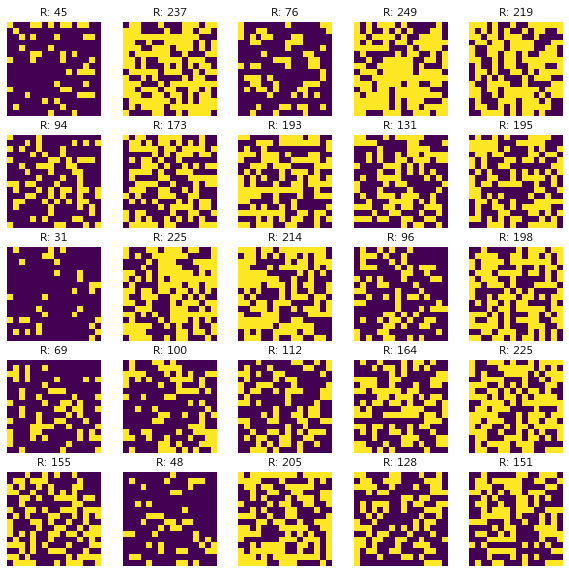

In [7]:
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i//plt_row, i%plt_col]  # //: 정수형 나누기
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt.set_title('R: %d' % (y_test[i][0]))  # R: 점의 수

plt.show()

In [8]:
# 데이터 준비
x_train, y_train = generate_dataset(3000) # 훈련용
x_test, y_test = generate_dataset(300)    # 테스트용 
width=16
height=16

# 데이터가 0 부터 255로 구성되어 있음으로 255로 나누어서 정규화
# 28 x 28 필셀의 흑백이미지(1) 60000장 구조 생성
# x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
# 28 x 28 필셀의 흑백이미지(1) 10000장 구조 생성
# x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 25%만 사용, 4개중에 최대값 1개만 다음 레이어로 전달
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=5)
start = time.time()
# 장비 속도가 느려 3번만 진행
hist = model.fit(x_train, y_train, validation_split = 0.33, 
                 shuffle=True, epochs=50, 
                 batch_size=50, callbacks=[early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# gpu: 9 초

Train on 2009 samples, validate on 991 samples
Epoch 1/50
2009/2009 [==============================] - 3s 1ms/sample - loss: 9535.5799 - val_loss: 1325.8647
Epoch 2/50
2009/2009 [==============================] - 2s 833us/sample - loss: 1201.2963 - val_loss: 736.9825
Epoch 3/50
2009/2009 [==============================] - 2s 844us/sample - loss: 757.0095 - val_loss: 390.6975
Epoch 4/50
2009/2009 [==============================] - 2s 837us/sample - loss: 437.8301 - val_loss: 160.7296
Epoch 5/50
2009/2009 [==============================] - 2s 852us/sample - loss: 325.1991 - val_loss: 104.5673
Epoch 6/50
2009/2009 [==============================] - 2s 837us/sample - loss: 302.3036 - val_loss: 99.4896
Epoch 7/50
2009/2009 [==============================] - 2s 862us/sample - loss: 273.7730 - val_loss: 104.1456
Epoch 8/50
2009/2009 [==============================] - 2s 834us/sample - loss: 279.0282 - val_loss: 102.2769
Epoch 9/50
2009/2009 [==============================] - 2s 831us/sample -

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 16)          0

No handles with labels found to put in legend.


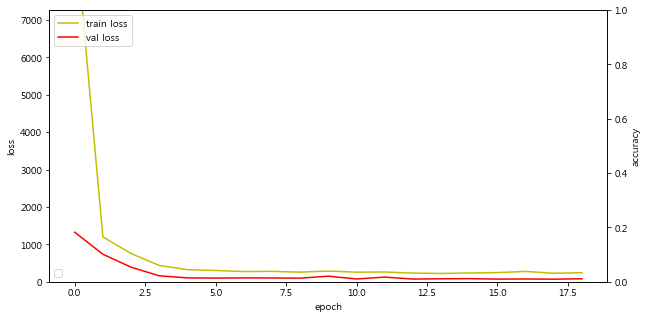

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 7265.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
# acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
# acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [11]:
yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

[[ 95.84162 ]
 [143.6901  ]
 [ 23.819284]
 [ 22.410313]
 [ 56.98222 ]
 [ 86.51165 ]
 [201.647   ]
 [ 98.01259 ]
 [ 63.493702]
 [ 78.563034]]


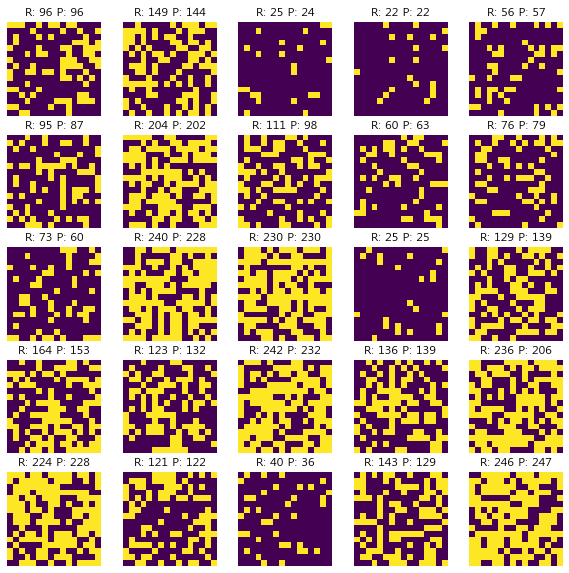

In [13]:
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i//plt_row, i%plt_col]  # //: 정수형 나누기
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt.set_title('R: %d P: %.0f' % (y_test[i][0], yp[i][0]))  # R: 실제값, P: 예측한 값

plt.show()